In [68]:
# stanのバージョンが v3.3 になり import pystan ではなくではなく import stan とライブラリ名がが
# 変わると当時に、build 時に以下のエラーがでるようになった。
# 対策としてnest_asyncio というライブラリを使う必要があるため、最初の一回のみライブラリをインストールしておくしておく
# 一回 install すれば、あとはこのコマンドは不要なので、先頭にに#をつけてコメントにしておいてください。
## RuntimeError: asyncio.run() cannot be called from a running event loop

!pip install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

input_dir = "/content/drive/MyDrive/input/"
output_dir = "/content/drive/MyDrive/output/"

# pystan と、パラメータの事後分布の推定結果を可視化するためのライブラリとして arviz を利用する。
import stan
import arviz
import nest_asyncio # stanのバージョンアップ対策
nest_asyncio.apply() # stanのバージョンアップ対策

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 二項ロジスティック回帰

被説明変数が質的データであっても分析ができるよう一般線形モデルを拡張したのが一般化線形モデル（GLM：Generalized Linear Model）です。一般線形モデルが、被説明変数が正規分布をしている時のみを扱っていることに比べて、一般化線形モデルは、正規分布以外の分布（二項分布、ポアソン分布等）に従う被説明変数を予測する時にも使われます。

ここでは、Stan による二項ロジスティック回帰モデルの推定方法を行います。

ロジスティック回帰モデルは、目的変数が量的変数の場合に使用されます。特に目的変数が2値 (1 or 0) の場合を二項ロジスティック回帰と呼びます。例えば1になる確率$p$を予測したい場合に用いられます。そのため確率分布にはベルヌーイ分布を用います。ただし、線形回帰では、目的変数と説明変数間に$ y = a + b_1 x_1 + b_2 x_2 + \cdots + b_m x_m $ の関係がなりたち、確率$p$を求めようとしても求めようとしても 0 と 1 の間には収まることが保証されていません。そこで、0から1の間に収まるようロジット変換と呼ばれる変数変換をします。

$$p_i = \mathrm{logit}^{-1}(a + b_1 x_1 + b_2 x_2 + \cdots + b_m x_m)$$
$$ y_i \sim \mathrm{bernoulli}(p_i) $$

ここで、$\mathrm{logit}(p) = \mathrm{log}(p/(1-p)) $ です。そして、logitの逆関数である$\mathrm{logit}^{-1} = 1/(1+\exp(-x))$で、シグモイド関数またはロジスティック関数とも呼ばれます。Stanでは inv_logit() 関数として用意されています。

なお、多項に拡張するためには、シグモイド関数を拡張したソフトマックス関数を活用することになります。

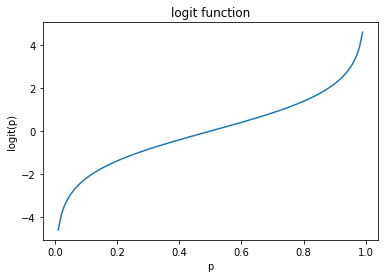

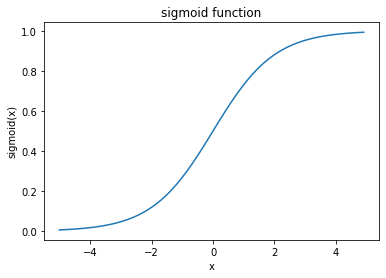

In [71]:
def logit(p):
  return  np.log(p/(1-p)) # オッズの対数

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

p = np.arange(0.01, 1.0, 0.01)
x = np.arange(-5, 5, 0.1)

plt.plot(p, logit(p))
plt.xlabel("p")
plt.ylabel("logit(p)")
plt.title("logit function")
plt.show()

plt.plot(x, sigmoid(x))
plt.xlabel("x")
plt.ylabel("sigmoid(x)")
plt.title("sigmoid function")
plt.show()

In [72]:
# タイタニックのデータ
data = pd.read_csv("https://raw.githubusercontent.com/matsuken92/Qiita_Contents/master/PyStan-Titanic/data/titanic_converted.csv", sep=",", header=0)

print (data.columns)
# survived: 生存（0/1），pclass:乗客クラス（1〜3），sex: 性別（male/female），age:年齢，sibsp:同乗の兄弟姉妹配偶者の数，parch:同乗の親子供の数，
# fare: 料金，embarked: 乗船港（C = Cherbourg, Q = Queenstown, S = Southampton），class:乗客クラス（First/Second/Third），
# who: 男女子供（man/woman/child，adult_male:成人男性（True/False），deck:デッキ（A〜G），embark_town:乗船港（Cherbourg/Queenstown/Southampton），
# alone: 一人旅（True/False）

data.head(10)

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alone'],
      dtype='object')


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,0,3,1,22.0,1,0,7.2500,1,3,1,1,0,3,1
1,1,1,0,38.0,1,0,71.2833,2,1,2,0,3,1,0
2,1,3,0,26.0,0,0,7.9250,1,3,2,0,0,3,0
3,1,1,0,35.0,1,0,53.1000,1,1,2,0,3,3,0
4,0,3,1,35.0,0,0,8.0500,1,3,1,1,0,3,1
5,0,3,1,28.0,0,0,8.4583,3,3,1,1,0,2,1
6,0,1,1,54.0,0,0,51.8625,1,1,1,1,5,3,1
7,0,3,1,2.0,3,1,21.0750,1,3,0,0,0,3,0
8,1,3,0,27.0,0,2,11.1333,1,3,2,0,0,3,0
9,1,2,0,14.0,1,0,30.0708,2,2,0,0,0,1,0


In [73]:
x = data[["pclass","sex", "age", "sibsp", "parch", "fare"]] # 複数の列番号を指定して抽出、data.iloc[:, [1,2,3,4,5,6]] も同じ。pclass, sex, age, sibsp, parch, fare を抽出
D = x 
D.insert(0, '(Intercept)', 1) # 先頭列に値が1の(Intercept)を追加
y = data['survived'].values # 目的変数の抽出。data.iloc[:, 0] も同じ。data.survived での抽出も同様。
x = x.values

print (y)
print (D.shape)
D.head()


[0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0
 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1
 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0
 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0
 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0
 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0
 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1
 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0
 0 0 1 1 0 1 0 0 1 0 0 0 

,(Intercept),pclass,sex,age,sibsp,parch,fare
0,1,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,1,3,1,35.0,0,0,8.0500


In [74]:
# Stan に入力するデータを作成
stan_data = {
    'N': D.shape[0], # データ数
    'K': D.shape[1], # 説明変数の数 + 1
    'x': D.values,
    'y': y
    }

stan_data

{'N': 891,
 'K': 7,
 'x': array([[ 1.    ,  3.    ,  1.    , ...,  1.    ,  0.    ,  7.25  ],
        [ 1.    ,  1.    ,  0.    , ...,  1.    ,  0.    , 71.2833],
        [ 1.    ,  3.    ,  0.    , ...,  0.    ,  0.    ,  7.925 ],
        ...,
        [ 1.    ,  3.    ,  0.    , ...,  1.    ,  2.    , 23.45  ],
        [ 1.    ,  1.    ,  1.    , ...,  0.    ,  0.    , 30.    ],
        [ 1.    ,  3.    ,  1.    , ...,  0.    ,  0.    ,  7.75  ]]),
 'y': array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 

In [75]:
stan_code = """
data {
  int N; // データ数
  int K; // 変数の数
  matrix[N, K] x; // 説明変数をNxM行列の matrix で宣言 
  int<lower=0, upper=1> y[N]; // 目的変数
}
parameters {
  vector[K] b; // 切片を含む係数ベクトルvectorで宣言, dot_productのように行列計算するときは real ではなくではなく vectorである必要があるらしいので注意
}
model {
  for (i in 1:N) {
    y[i] ~ bernoulli(inv_logit(dot_product(x[i], b))); // dot_product は内積を計算する. 
  }
}
"""

In [76]:
model = stan.build(stan_code, data=stan_data, random_seed=1)
# MCMCの実行
fit = model.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)

Building...



Building: 28.3s, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   1% (100/12000)
Sampling:   2% (200/12000)
Sampling:   2% (300/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:  25% (3000/12000)
Sampling:  25% (3001/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3400/12000)
Sampling:  29% (3500/12000)
Sampling:  31% (3700/12000)
Sampling:  32% (3800/12000)
Sampling:  50% (6000/12000)
Sampling:  50% (6001/12000)
Sampling:  51% (6100/12000)
Sampling:  52% (6200/12000)
Sampling:  52% (6300/12000)
Sampling:  53% (6400/12000)
Sampling:  54% (6500/12000)
Sampling:  55% (6600/12000)
Sampling:  56% (6700/12000)
Sampling:  57% (6800/12000)
Sampling:  58% (6900/12000)
Sampling:  75% (9000/12000)
Sampling:  75% (9001/12000)
Sampling:  76% (9100/12000)
Sampling:  77% (9200/12000)
Sampling:  78% (9300/12000)
Sampling:  78% (9400/12000)
Sampling:  79% (9500/12000)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[0],3.725,2.221,-0.041,5.744,1.086,0.829,7.0,13.0,1.59
b[1],-0.786,0.543,-1.291,0.137,0.265,0.202,7.0,11.0,1.59
b[2],-1.889,1.568,-3.074,0.814,0.778,0.596,7.0,13.0,1.59
b[3],-0.317,0.481,-1.183,-0.024,0.240,0.184,7.0,11.0,1.60
b[4],-0.645,0.500,-1.497,-0.213,0.245,0.190,7.0,27.0,1.53
b[5],0.363,0.832,-0.276,1.797,0.412,0.318,7.0,12.0,1.58
b[6],0.058,0.095,-0.000,0.226,0.047,0.036,7.0,11.0,1.59


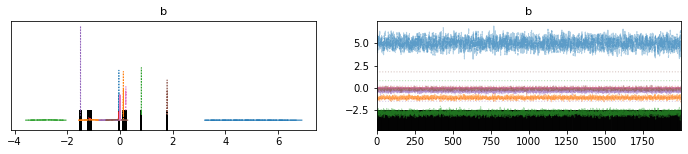

In [77]:
# MCMCの経過を簡易表示, muとsigmaのiter変化が見られる
arviz.plot_trace(fit)

#  Gelman-Rubin 統計量 (r_hat)、Highest density interval (HDI) などの簡易表示
summary = arviz.summary(fit)
summary

In [81]:
result = fit.to_frame()

# 統計量の概要を確認
print(result.describe().T)

# 先頭を表示
result.head()

                count         mean          std          min          25%  \
parameters                                                                  
lp__           8000.0 -2326.615335  3342.923819 -8492.751493 -2234.583294   
accept_stat__  8000.0     0.899081     0.154433     0.000000     0.874932   
stepsize__     8000.0     0.100267     0.057736     0.004926     0.089368   
treedepth__    8000.0     4.018125     1.128918     0.000000     4.000000   
n_leapfrog__   8000.0    23.926000    12.954420     1.000000    15.000000   
divergent__    8000.0     0.249750     0.432895     0.000000     0.000000   
energy__       8000.0  2330.188063  3343.124232   395.517752   400.079703   
b.1            8000.0     3.725029     2.220783    -0.040553     2.399075   
b.2            8000.0    -0.786077     0.542729    -1.580200    -1.149000   
b.3            8000.0    -1.888827     1.568430    -3.597644    -2.871679   
b.4            8000.0    -0.317494     0.481118    -1.196132    -0.327307   

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b.1,b.2,b.3,b.4,b.5,b.6,b.7
draws,,,,,,,,,,,,,,
0,-397.118822,0.996279,0.118151,5.0,31.0,0.0,403.568987,5.273726,-1.194659,-3.012838,-0.035052,-0.202554,-0.211977,0.001113
1,-8489.561023,0.873848,0.004926,3.0,8.0,1.0,8492.485143,-0.038485,0.127626,0.812077,-1.195972,-1.494258,1.790615,0.226064
2,-401.224930,0.820416,0.160474,5.0,31.0,0.0,402.334094,3.868558,-0.782279,-2.543846,-0.040550,-0.364775,-0.268965,0.010120
3,-396.919492,0.943296,0.117516,5.0,47.0,0.0,400.808312,5.145176,-1.058291,-3.154617,-0.038807,-0.341982,-0.183378,0.002723
4,-397.710762,0.967673,0.118151,4.0,31.0,0.0,401.208866,5.285523,-1.202971,-3.054830,-0.038898,-0.261473,-0.000549,0.000789


In [82]:
# パラメータのトレースプロットと事後分布を可視化する関数を自作
def plot_trace(param, param_name='parameter'):  
  mean = np.mean(param) # 平均値（期待値） 
  median = np.median(param) # 中央値
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5) # 95%信頼区間
  
  # トレースプロット
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='red', linestyle='--')
  plt.axhline(median, color='black', linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='gray') # 95%信頼区間の範囲を表記
  plt.axhline(cred_max, linestyle=':', color='gray')
  plt.title('Trace for ' + param_name)
  plt.show()

  # 事後分布
  plt.hist(param, 30, density=True)
  #sns.kdeplot(param, shade=True) # カーネル密度関数を可視化する。。seabornも使えるようになっていると素敵なグラフが作れる。
  plt.axvline(mean, color='red', linestyle='--',label='mean')
  plt.axvline(median, color='black', linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='gray', label='95% CI') # 95%信頼区間の範囲を表記
  plt.axvline(cred_max, linestyle=':', color='gray')  
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.legend()
  plt.title('Posterior Distribution for ' + param_name)
  plt.show()

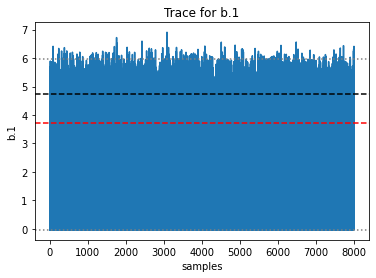

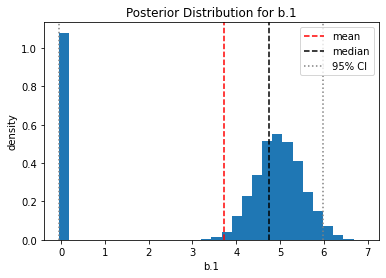

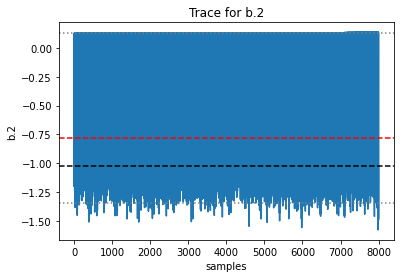

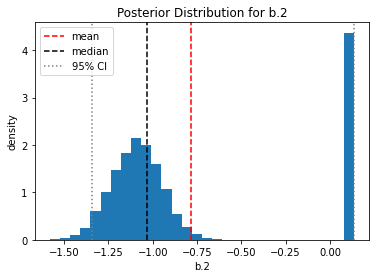

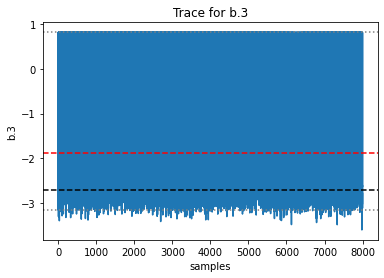

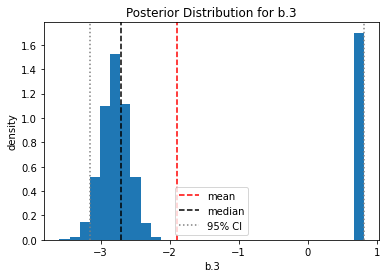

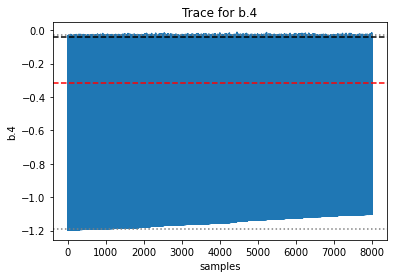

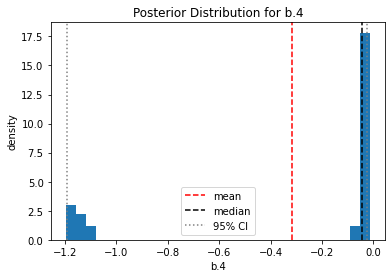

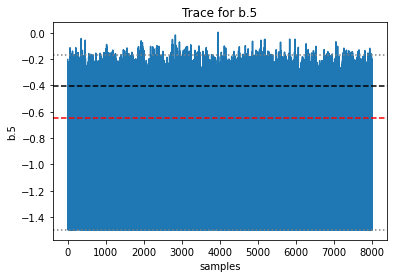

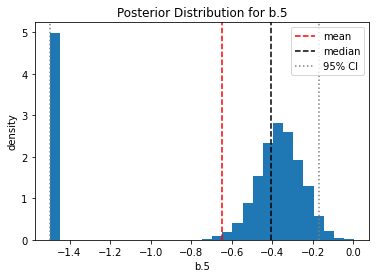

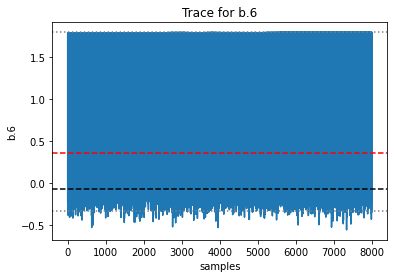

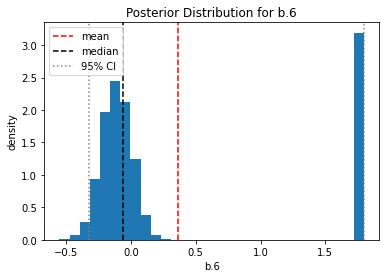

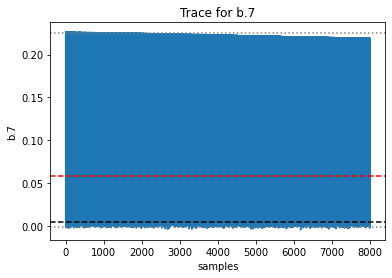

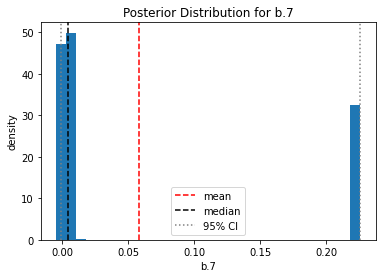

In [87]:
for i in range (1, D.shape[1] + 1):
  name = "b." + str(i)
  plot_trace(result[name], name)